In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.datasets import make_spd_matrix
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.stats import multivariate_normal
from scipy.io import loadmat

#### Load data set

In [2]:
cardio_data = loadmat('cardio.mat')
X = cardio_data['X']
y = cardio_data['y']

### Data Visualization

Using Principle Component Analysis to project 21-dimensional features into 2-dimensional data to gain some intuition into the relationships between these points.

In [3]:
pca = PCA(n_components=2)
projected_X = pca.fit_transform(X)

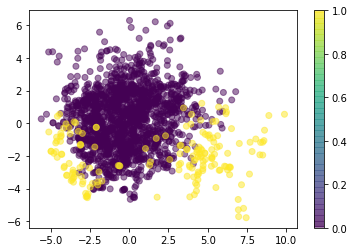

In [4]:
plt.scatter(projected_X[:, 0], projected_X[:, 1], c=y.flatten(), alpha=.5);
plt.colorbar();

### GMM Implemention

In [5]:
class GaussianMixture:

    def __init__(self, n_components=1, tol=0.001, init_params='random', max_iter=100):
        assert n_components > 0
        assert tol != 0
        assert init_params in {'random', 'kmeans'}
        assert max_iter > 0
        
        self.n_components = n_components
        self.tol = tol
        self.max_iter = max_iter
        self.init_params = init_params
          
    def __assertion(self, X):
        N, D = X.shape
        assert self.weights.shape == (self.n_components, )
        assert self.means.shape == (self.n_components, D)
        assert self.covs.shape == (self.n_components, D, D)
            
    def __init_params(self, X):
        N, D = X.shape
        
        # Responsibilities are initialized randomly
        if self.init_params == 'random':
            self.means = np.random.choice(X.flatten(), size=(self.n_components, D))
        
        # Responsibilities are initialized using KMeans
        elif self.init_params == 'kmeans':
            kmeans = KMeans(n_clusters=self.n_components, tol=self.tol, max_iter=self.max_iter)
            kmeans.fit(X)
            self.means = kmeans.cluster_centers_
        
        self.weights = np.ones(self.n_components) / self.n_components
        self.covs = np.array([make_spd_matrix(D) for _ in range(self.n_components)])
        self.__assertion(X)
    
    def predict_prob(self, X):
        """
        Predict posterior probability of each component given the data.
        
        Args:
        X: List of data points. Each row corresponds to a single data point.
        
        Returns:
        Probability each Gaussian (state) in the model given each sample.
        """
        
        return np.array([multivariate_normal.pdf(X, self.means[k], self.covs[k], 
                                                 allow_singular=True) * self.weights[k]
                         for k in range(self.n_components)])
    
    def __expectation(self, X):
        """
        Calculate the expectation of the component assignments C_k for each data point x
        given the model parameters.
        
        Args:
        X: List of data points. Each row corresponds to a single data point.
        
        Returns:
        Likelihood of a given each sample belong to each cluster.
        """
        
        N, D = X.shape
        probs = self.predict_prob(X)
        probs /= np.sum(probs, axis=0)
        assert probs.shape == (self.n_components, N)  
        return probs
        
    def __maximization(self, X, probs):
        """
        Maximize the expectations calculated in the expectation step with respect to
        the model parameters, consists of updating weights, means, and covariances.
        
        Args:
        X: List of data points. Each row corresponds to a single data point.
        probs: List of likelihoods. k-th column corresponds to likelihood of a data point
        belong to the k-th cluster.
        """
        
        N, D = X.shape     
        
        for k in range(self.n_components):
            k_raised_prob = probs[k].reshape(N, 1)        
            k_total_prob = np.sum(probs[k])
            self.weights[k] = k_total_prob / N
            self.means[k] = np.sum(k_raised_prob * X, axis=0) / k_total_prob           
            diff_k = (X - self.means[k])
            self.covs[k] = np.dot((k_raised_prob * diff_k).T, diff_k) / k_total_prob
        
        self.__assertion(X)
    
    def __em(self, X):
        probs = self.__expectation(X)
        self.__maximization(X, probs)  
    
    def fit(self, X):
        self.__init_params(X)
        for _ in range(self.max_iter):
            self.__em(X)
    
    def predict(self, X):
        return np.argmax(self.predict_prob(X), axis=0).reshape(-1, 1)

### Training

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=202, stratify=y)

Visualize training and testing data distribution

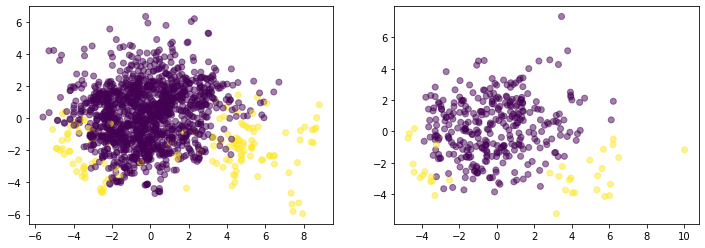

In [7]:
X_train_pca = PCA(n_components=2).fit_transform(X_train)
X_test_pca = PCA(n_components=2).fit_transform(X_test)
fig, (train_ax, test_ax) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
train_ax.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train.flatten(), alpha=.5);
test_ax.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test.flatten(), alpha=.5);

In [9]:
from sklearn.mixture import GaussianMixture as skGaussianMixture
gmm = GaussianMixture(n_components=2, init_params='kmeans')
sk_gmm = skGaussianMixture(n_components=2, init_params='kmeans')
gmm.fit(X_train);
sk_gmm.fit(X_train);

### Detect anormality using GMM

In [10]:
y_predict = gmm.predict(X_test)
sk_y_predict = sk_gmm.predict(X_test)

### Model Evaluation (compare to Sklearn's Gaussian Mixture)

In [11]:
from sklearn.metrics import classification_report, roc_auc_score
print(classification_report(y_test, y_predict))
print(roc_auc_score(y_test, y_predict))
print(classification_report(y_test, sk_y_predict))
print(roc_auc_score(y_test, sk_y_predict))

              precision    recall  f1-score   support

         0.0       0.95      0.78      0.86       332
         1.0       0.22      0.60      0.33        35

    accuracy                           0.76       367
   macro avg       0.59      0.69      0.59       367
weighted avg       0.88      0.76      0.81       367

0.6900602409638554
              precision    recall  f1-score   support

         0.0       0.95      0.87      0.91       332
         1.0       0.32      0.57      0.41        35

    accuracy                           0.84       367
   macro avg       0.64      0.72      0.66       367
weighted avg       0.89      0.84      0.86       367

0.7224612736660929
